In [4]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [6]:
#/kaggle/input/emnist/emnist-letters-mapping.txt
testing_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-test.csv')
training_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-train.csv')
print(training_data.shape)
print(testing_data.shape)

(88799, 785)
(14799, 785)


In [7]:
X_train = np.array(training_data.iloc[:,1:].values)
y_train = np.array(training_data.iloc[:,0].values)

X_test = np.array(testing_data.iloc[:,1:].values)
y_test = np.array(testing_data.iloc[:,0].values)

print(X_train.shape)
print(y_train.shape)

(88799, 784)
(88799,)


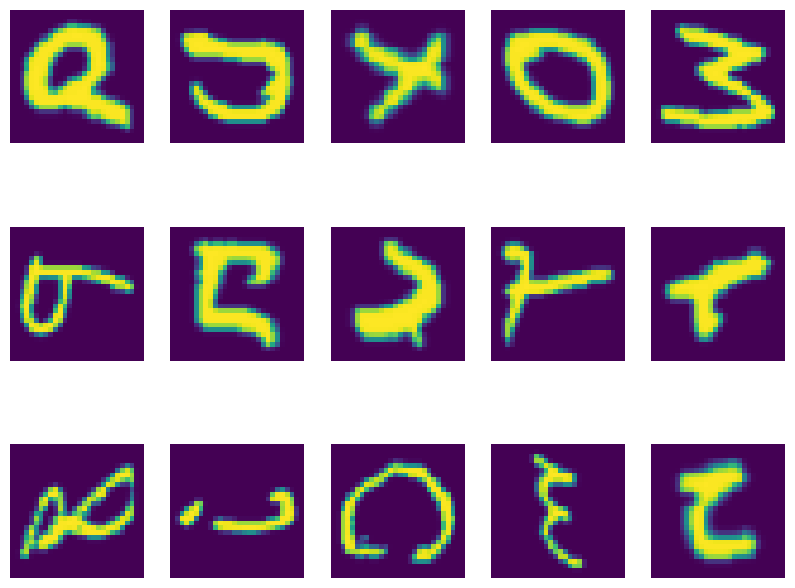

In [8]:
 from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42) 

fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28,28]))
    ax.axis('off')

In [9]:
print(X_test.shape)
print(y_test.shape)

(14799, 784)
(14799,)


In [10]:
np.unique(y_train)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [11]:
np.unique(y_test)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [12]:
print(len(y_train)+len(y_test))


103598


In [13]:
print(len(X_train) + len(X_test))


103598


In [14]:
X = np.concatenate((X_train, X_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)
print(y.shape)

(103598,)


In [15]:
X.shape


(103598, 784)

In [16]:
np.unique(y)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [17]:
X_norm = X.astype('float32') / 255.0 

X_reshaped = X.reshape(-1, 28, 28, 1)

X_rgb = np.repeat(X_reshaped, 3, axis=-1)

print("Images shape after RGB conversion:", X_rgb.shape)

Images shape after RGB conversion: (103598, 28, 28, 3)


In [18]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y.reshape(-1, 1))

y_encoded = encoder.transform(y.reshape(-1, 1))

print("images shape:", X_rgb.shape)
print("labels shape:", y_encoded.shape)

images shape: (103598, 28, 28, 3)
labels shape: (103598, 26)


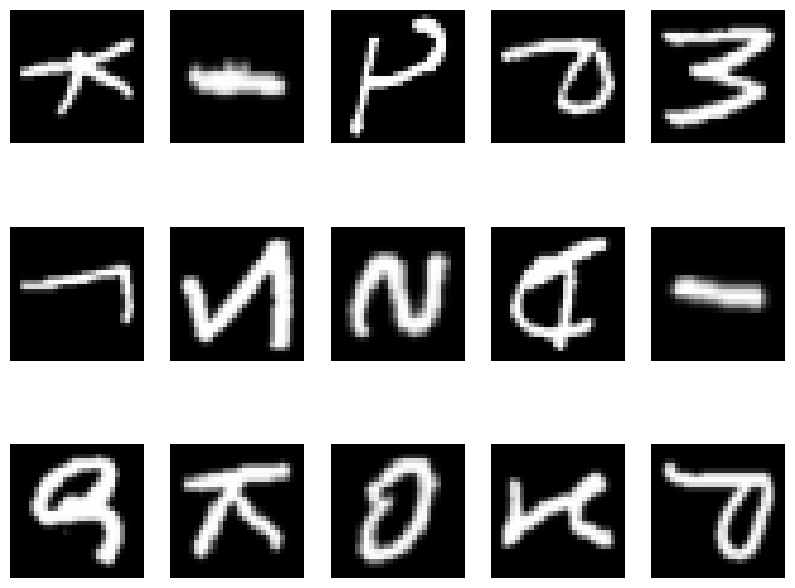

In [19]:
X_shuffled, y_shuffled = shuffle(X_rgb, y, random_state=42)

# Visualize the reshaped EMNIST images in RGB
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_shuffled[i])
    ax.axis('off')

In [20]:
from sklearn.model_selection import train_test_split

# Shuffle and split into 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_rgb, y_encoded, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(82878, 28, 28, 3)
(82878, 26)
(20720, 28, 28, 3)
(20720, 26)


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')


datagen.fit(X_train)
datagen.fit(X_val)
print('Done')

Done


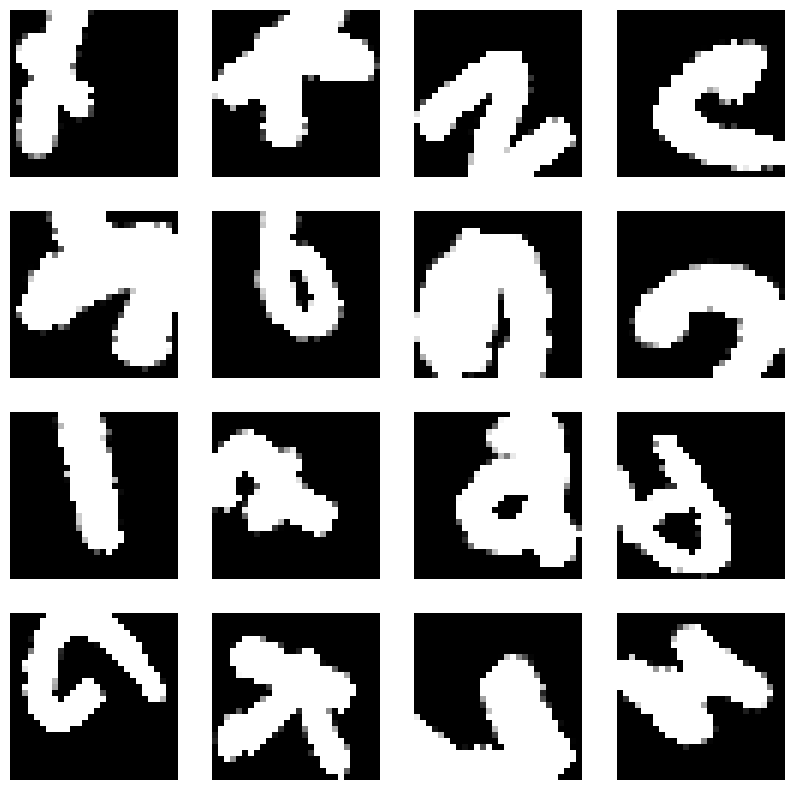

In [22]:
augmented_images = datagen.flow(X_train, batch_size=1, shuffle=True)

plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_img = next(augmented_images)[0].astype('float32')
    plt.subplot(4, 4, i+1) 
    plt.imshow(augmented_img)
    plt.axis('off')
plt.show()

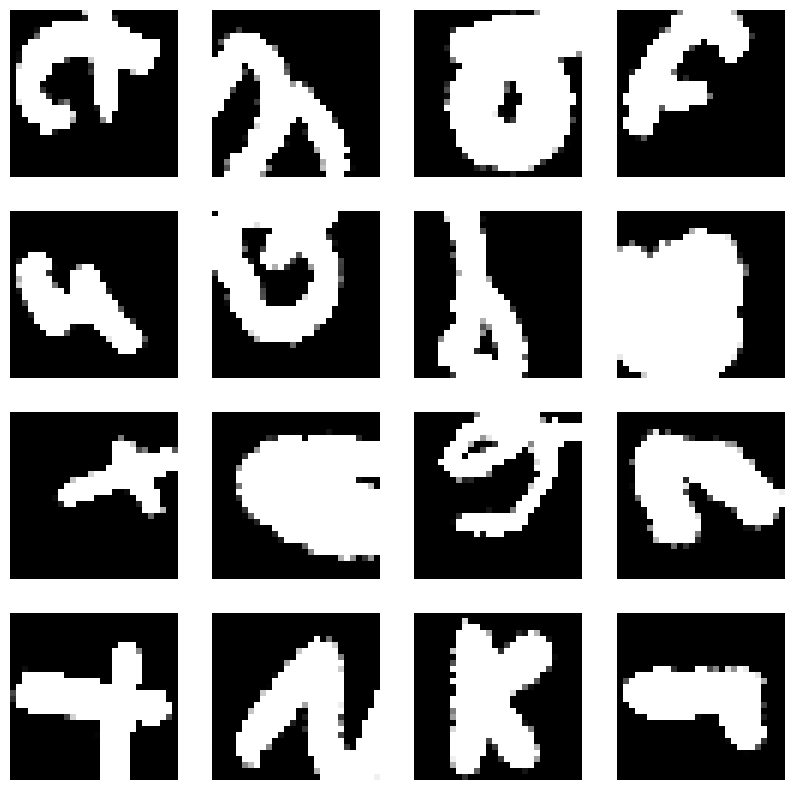

In [23]:
augmented_images = datagen.flow(X_val, batch_size=1, shuffle=True)

plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_img = next(augmented_images)[0].astype('float32')
    plt.subplot(4, 4, i+1) 
    plt.imshow(augmented_img)
    plt.axis('off')
plt.show()

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [25]:
import os

# Suppress logging warnings
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

In [26]:
# Resizing images_DenseNet input shape 
IMAGE_SIZE = 64
X_train_resized = tf.image.resize(X_train, (IMAGE_SIZE, IMAGE_SIZE))
X_val_resized = tf.image.resize(X_val, (IMAGE_SIZE, IMAGE_SIZE))

In [27]:
#DenseNet_Model
def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # Freeze the first few layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(26, activation='softmax')(x)  # 26 classes for EMNIST letters

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [28]:
# Compile DenseNet Model
model = create_densenet_model()
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [29]:
# Callbacks for efficient training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Create the datasets using tf.data for efficient data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_resized, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_resized, y_val))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [30]:
#Train DenseNet
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,  
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 259s 62ms/step - accuracy: 0.6237 - loss: 1.4630 - val_accuracy: 0.9351 - val_loss: 0.1999 - learning_rate: 1.0000e-04
Epoch 2/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - accuracy: 0.9093 - loss: 0.2930 - val_accuracy: 0.9357 - val_loss: 0.2034 - learning_rate: 1.0000e-04
Epoch 3/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - accuracy: 0.9260 - loss: 0.2343 - val_accuracy: 0.9432 - val_loss: 0.1831 - learning_rate: 1.0000e-04
Epoch 4/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - accuracy: 0.9383 - loss: 0.1929 - val_accuracy: 0.9446 - val_loss: 0.1724 - learning_rate: 1.0000e-04
Epoch 5/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - accuracy: 0.9434 - loss: 0.1661 - val_accuracy: 0.9439 - val_loss: 0.1762 - learning_rate: 1.0000e-04
Epoch 6/10
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - accuracy: 0.9469 - loss: 0.1525 - val_accuracy: 0.9453 - val_loss: 0.1806 - learning_rate: 1.0000e-04
Epoch 7/10
2590/2590 ━━━━━━━━━━━━━━━━━━

In [31]:
for layer in model.layers[100:]:  
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tunin
model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Continue training the model with fine-tuning
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,  # Additional epochs 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 244s 60ms/step - accuracy: 0.9675 - loss: 0.0804 - val_accuracy: 0.9541 - val_loss: 0.1647 - learning_rate: 1.0000e-05
Epoch 2/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 100s 39ms/step - accuracy: 0.9705 - loss: 0.0722 - val_accuracy: 0.9537 - val_loss: 0.1723 - learning_rate: 1.0000e-05
Epoch 3/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 103s 40ms/step - accuracy: 0.9720 - loss: 0.0667 - val_accuracy: 0.9529 - val_loss: 0.1757 - learning_rate: 1.0000e-05
Epoch 4/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 103s 40ms/step - accuracy: 0.9734 - loss: 0.0617 - val_accuracy: 0.9523 - val_loss: 0.1876 - learning_rate: 1.0000e-05
Epoch 5/5
2590/2590 ━━━━━━━━━━━━━━━━━━━━ 100s 39ms/step - accuracy: 0.9755 - loss: 0.0571 - val_accuracy: 0.9539 - val_loss: 0.1867 - learning_rate: 2.0000e-06


Final Training Accuracy: 0.9776780605316162
Final Validation Accuracy: 0.9539092779159546


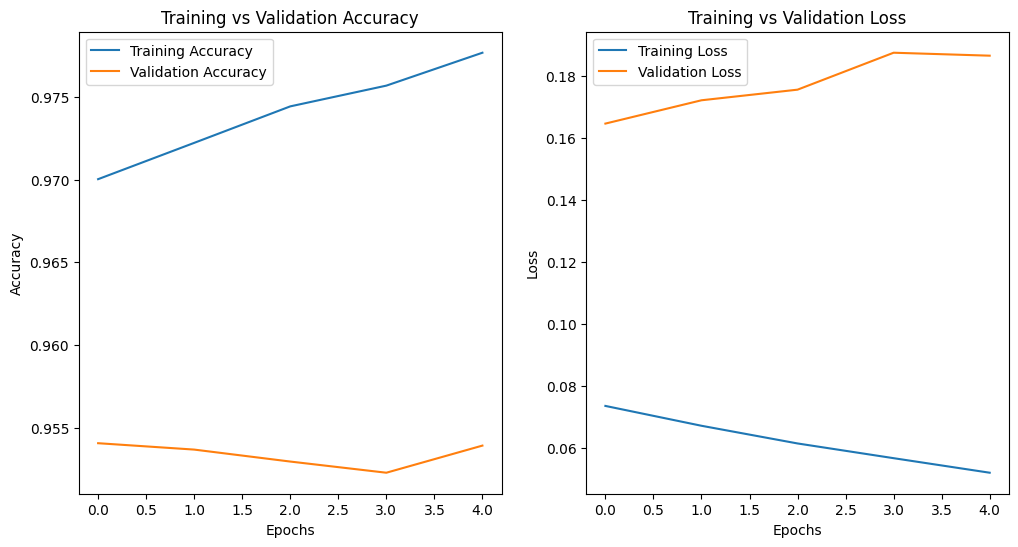

In [32]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Access final accuracies
final_train_accuracy = history_fine_tune.history['accuracy'][-1]
final_val_accuracy = history_fine_tune.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Accuracy: {final_val_accuracy}")

# Call the plotting function
plot_training_history(history_fine_tune)


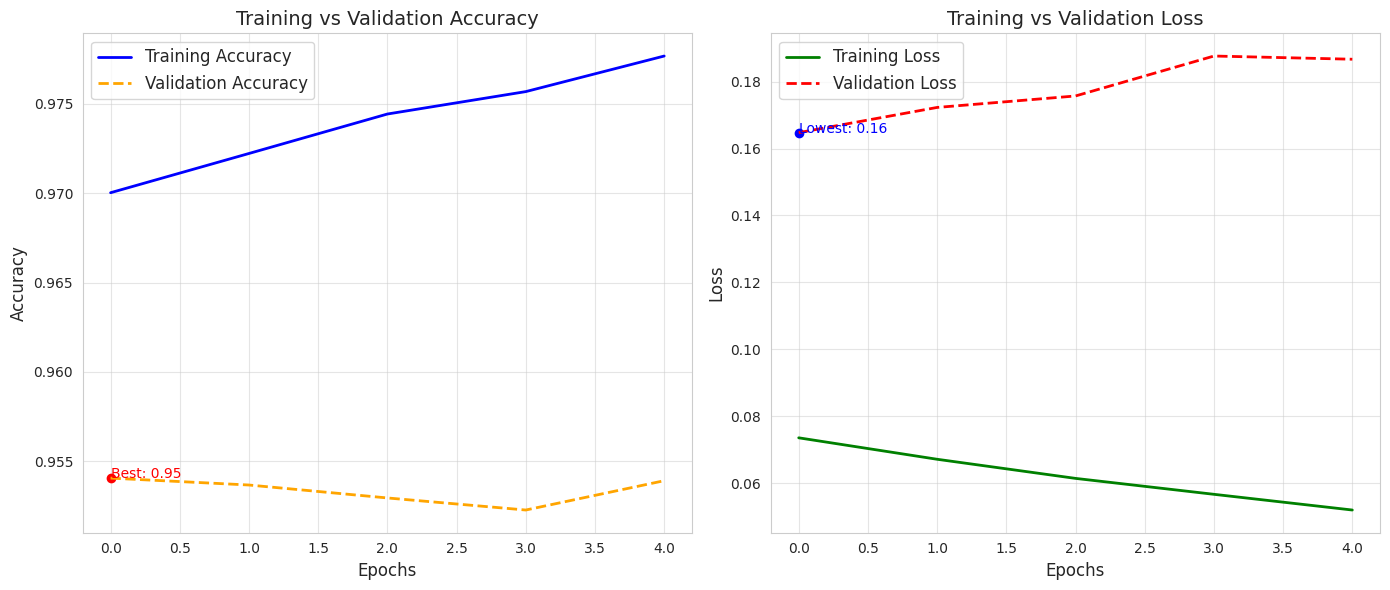

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history):
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 6))

    # Accuracy visualization
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
    plt.title('Training vs Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)

    # Annotate the highest validation accuracy
    best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    best_val_accuracy = max(history.history['val_accuracy'])
    plt.scatter(best_epoch, best_val_accuracy, color='red')
    plt.text(best_epoch, best_val_accuracy, f'Best: {best_val_accuracy:.2f}', fontsize=10, color='red')

    # Loss visualization
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='green', linestyle='-', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)
    plt.title('Training vs Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)

    # Annotate the lowest validation loss
    best_epoch_loss = history.history['val_loss'].index(min(history.history['val_loss']))
    best_val_loss = min(history.history['val_loss'])
    plt.scatter(best_epoch_loss, best_val_loss, color='blue')
    plt.text(best_epoch_loss, best_val_loss, f'Lowest: {best_val_loss:.2f}', fontsize=10, color='blue')

    plt.tight_layout()
    plt.show()

# Call the function to visualize the training history
plot_training_history(history_fine_tune)


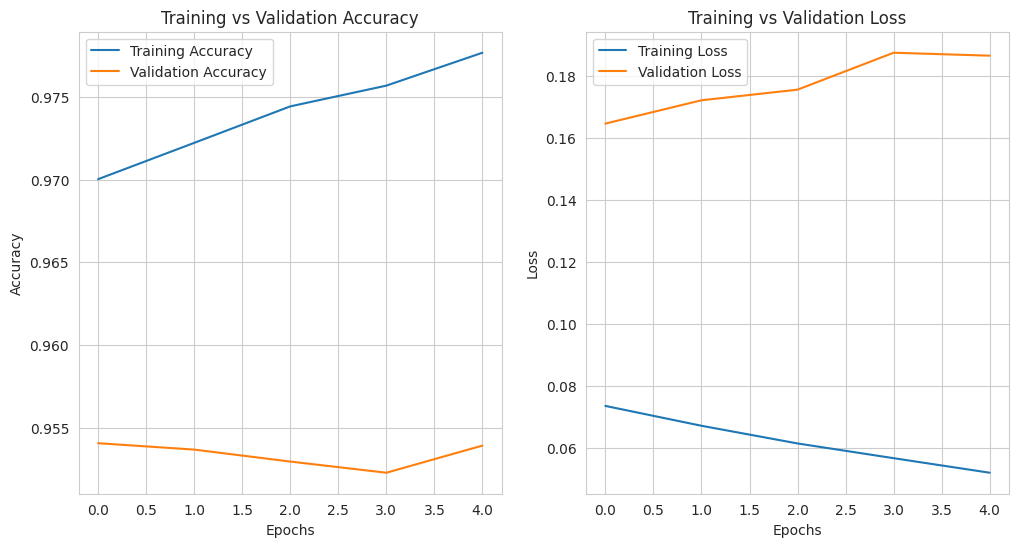

In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_training_history(history_fine_tune)

648/648 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step


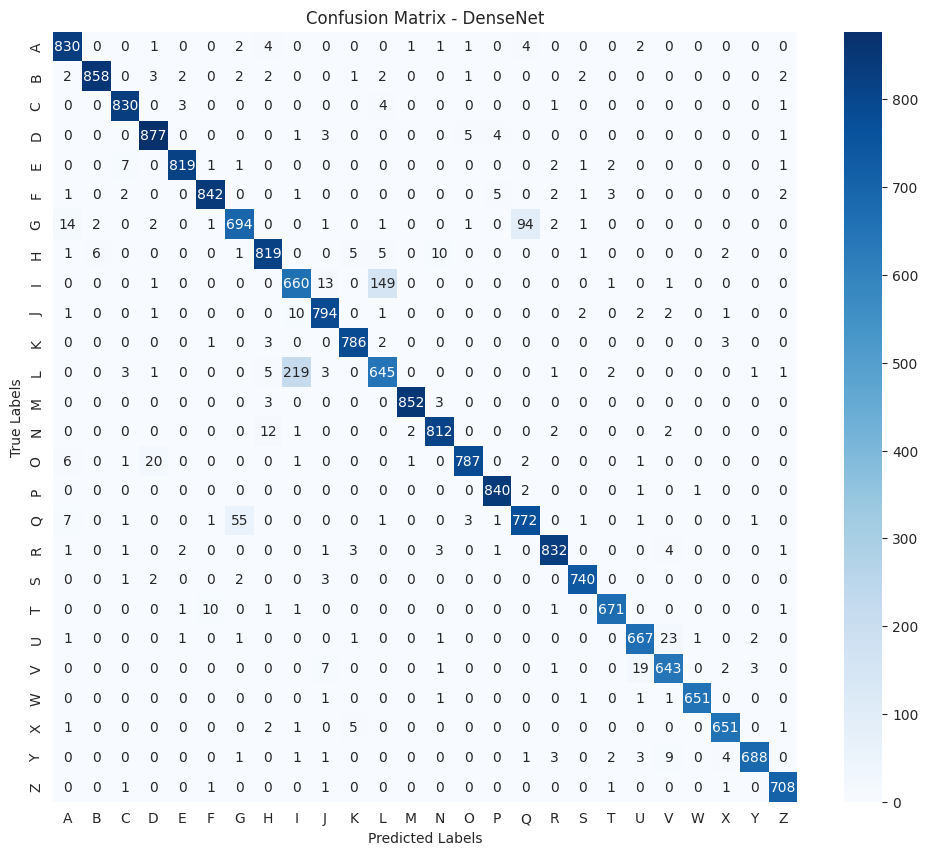

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


val_predictions = model.predict(X_val_resized)
val_pred_labels = np.argmax(val_predictions, axis=1)  # Convert probabilities to class labels
true_labels = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class labels

# Define class names
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Compute confusion matrix
cm = confusion_matrix(true_labels, val_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - DenseNet')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [36]:
from sklearn.metrics import classification_report

# Classification Report (Precision, Recall, F-Score)
report = classification_report(true_labels, val_pred_labels, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

           A     0.9595    0.9811    0.9702       846
           B     0.9908    0.9783    0.9845       877
           C     0.9799    0.9893    0.9846       839
           D     0.9659    0.9843    0.9750       891
           E     0.9891    0.9820    0.9856       834
           F     0.9825    0.9802    0.9814       859
           G     0.9144    0.8536    0.8830       813
           H     0.9624    0.9635    0.9630       850
           I     0.7366    0.8000    0.7670       825
           J     0.9589    0.9754    0.9671       814
           K     0.9813    0.9887    0.9850       795
           L     0.7963    0.7321    0.7629       881
           M     0.9953    0.9930    0.9942       858
           N     0.9760    0.9771    0.9765       831
           O     0.9862    0.9609    0.9734       819
           P     0.9871    0.9953    0.9912       844
           Q     0.8823    0.9147    0.8982       844
           R     0.9823    

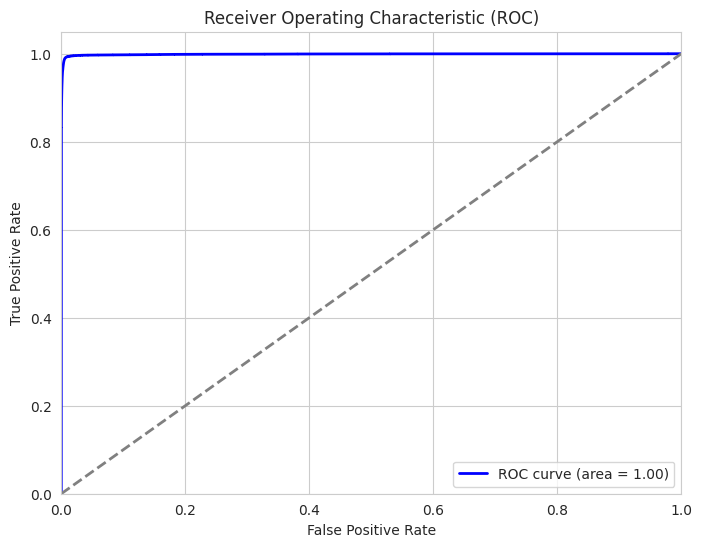

In [37]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

lb = LabelBinarizer()
y_val_bin = lb.fit_transform(true_labels)  
y_pred_bin = lb.transform(val_pred_labels)  

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val_bin.ravel(), val_predictions.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [38]:
# AUC Score
print(f"AUC: {roc_auc:.4f}")

AUC: 0.9988


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute Precision, Recall, and F-Score
precision = precision_score(true_labels, val_pred_labels, average='weighted')
recall = recall_score(true_labels, val_pred_labels, average='weighted')
fscore = f1_score(true_labels, val_pred_labels, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {fscore:.4f}')

Precision: 0.9543
Recall: 0.9541
F1 Score: 0.9540


648/648 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


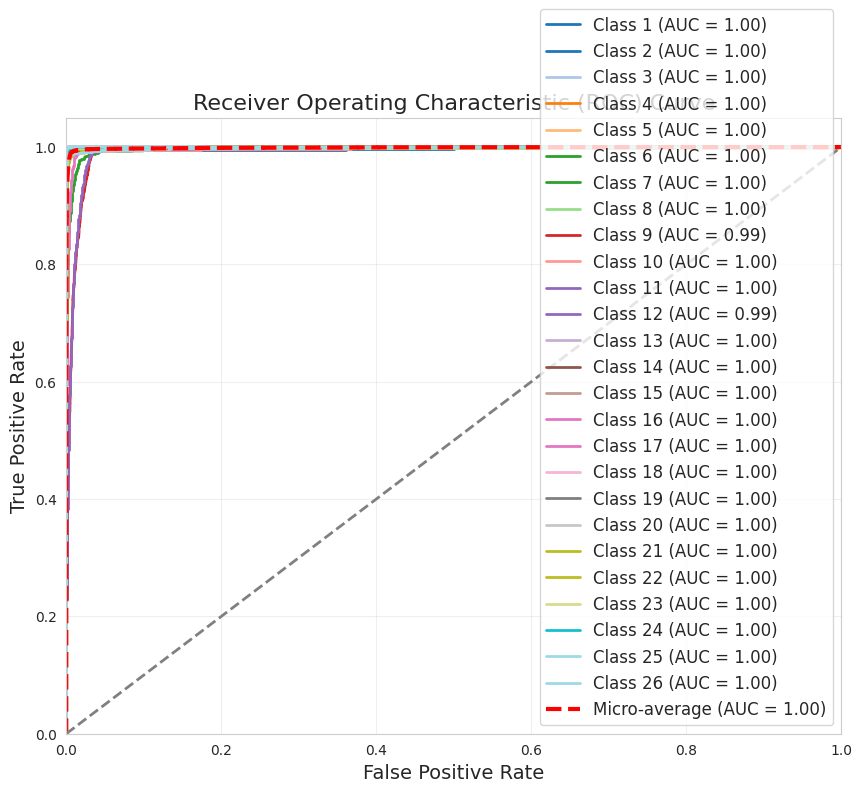

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder

# Assuming X_val_resized and y_val are already prepared as per your code
# and your model has been trained and fine-tuned

# Get predictions for the validation set
y_pred_prob = model.predict(X_val_resized)

# Initialize lists to store the fpr, tpr, and auc values
fpr = {}
tpr = {}
roc_auc = {}

# Number of classes (EMNIST has 26 classes)
num_classes = 26

# Calculate ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab20', num_classes)  # Use tab20 color map for distinct colors

# Plot the ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'Class {i+1} (AUC = {roc_auc[i]:0.2f})')

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='red', lw=3, linestyle='--', label=f'Micro-average (AUC = {roc_auc["micro"]:0.2f})')

# Plot the diagonal line (no-skill classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

